In [1]:
# %pip install -q -U bitsandbytes
# %pip install datasets -U
# %pip install -q -U git+https://github.com/huggingface/transformers.git
# %pip install -q -U git+https://github.com/huggingface/peft.git
# %pip install -q -U git+https://github.com/huggingface/accelerate.git
# %pip install pandas
# %pip install wandb

In [2]:
import os
import torch
import pandas as pd
import bitsandbytes as bnb

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)

from peft import (
    PeftModel,
    PeftConfig,
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)

from huggingface_hub import login
from datasets import load_dataset

from dotenv import load_dotenv
load_dotenv("../keys.env")
hf_token = os.getenv("HF_TOKEN")
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
data_id = "Bingsu/ko_alpaca_data" ## "nlpai-lab/kullm-v2"
model_id = "beomi/Llama-3-Open-Ko-8B" ## "meta-llama/Meta-Llama-3.1-8B-Instruct"

val_size = 0.005
max_seq_len = 256 ## 4098
train_on_inputs = True
add_eos_token = True

In [4]:
dataset = load_dataset(data_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [5]:
tokenizer.all_special_tokens

['<|begin_of_text|>', '<|end_of_text|>']

In [6]:
bos = tokenizer.bos_token_id
eos = tokenizer.eos_token_id

tokenizer.pad_token_id = eos
tokenizer.padding_side = "right"

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 49620
    })
})

In [8]:
df = pd.DataFrame(dataset['train'])
df.head()

,instruction,input,output
0,건강을 유지하기 위한 세 가지 팁을 알려주세요.,,"세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는..."
1,세 가지 기본 색은 무엇인가요?,,"기본 색은 빨강, 파랑, 노랑입니다."
2,원자의 구조를 설명하세요.,,"원자는 양성자, 중성자, 전자로 구성되어 있으며, 양성자와 중성자는 원자핵 안에 있..."
3,대기 오염을 어떻게 줄일 수 있나요?,,"대기 오염을 줄이기 위해 자동차 대신 대중교통을 이용하고, 미세먼지 배출량을 줄이기..."
4,어려운 결정을 내려야 했던 때를 설명하세요.,,제가 어려운 결정을 내려야 했던 때는 대학원 졸업 후 직장을 찾아야 했던 때입니다....


In [9]:
from random import randint

rand_idx = randint(0, df.shape[0])
sample_row = df.iloc[rand_idx]

print(rand_idx)
print(f"input : \n{sample_row['input']}\n\n")
print(f"instruction : \n{sample_row['instruction']}\n\n")
print(f"output : \n{sample_row['output']}\n\n")

19281
input : 



instruction : 
산성비와 일반 비의 차이점을 설명하세요.


output : 
산성비는 대기 중의 다양한 화학 물질에서 유기산산, 황산, 질산 등의 산성 물질이 함유된 비를 말합니다. 반면, 일반 비는 이산화탄소, 산소, 질소, 수증기 등의 순수한 물로 이루어져 있습니다.




In [10]:
from typing import Union

template = {
    "prompt_input": "아래는 문제를 설명하는 지시사항과 구체적인 답변 방식을 요구하는 입력이 함께 있는 문장입니다. 이 요청에 대해 적절하게 답변해주세요.\n###입력:{input}\n###지시사항:{instruction}\n###답변:",
    "prompt_no_input": "아래는 문제를 설명하는 지시사항입니다. 이 요청에 대해 적절하게 답변해주세요.\n###지시사항:{instruction}\n###답변:"
}

def generate_prompt(instruction : str, input : Union[None, str]=None, label : Union[None, str]=None, verbose : bool = False):
    if input:
        result = template["prompt_input"].format(instruction=instruction, input=input)
    else:
        result = template["prompt_no_input"].format(instruction=instruction)

    if label:
        result = f"{result}{label}"
    
    if verbose:
        print(result)

    return result

In [11]:
def tokenize(prompt, max_seq_len, add_eos_token=True):
    result = tokenizer(prompt, 
                       truncation=True, ## 최대 길이를 초과하는 경우 자르기 수행
                       max_length=max_seq_len, ## 최대 시퀀스 길이 설정
                       padding=False, ## 패딩 비활성화. True로 설정하면 배치 내 모든 시퀀스가 max_length에 맞춰짐
                       return_tensors=None)
    
    ## 토큰화된 시퀀스 데이터의 마지막이 eos 토큰이 아니며, 시퀀스 길이가 max_seq_len보다 작고, add_eos_token이 True일 경우
    ## eos_token을 시퀀스 마지막에 추가하며 attention_mask의 마지막에 1을 추가한다.
    if(result["input_ids"][-1] != tokenizer.eos_token_id
       and len(result["input_ids"]) < max_seq_len
       and add_eos_token):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

In [12]:
def generate_and_tokenize_prompt(data_point, train_on_inputs, max_seq_len, add_eos_token):
    ## 원천 데이터를 알파카 프롬프트로 변환.
    full_prompt = generate_prompt(data_point["instruction"], data_point["input"], data_point["output"])

    ## 토크나이징.
    tokenized_full_prompt = tokenize(full_prompt, max_seq_len, add_eos_token)
    
    ## train_on_inputs == False인 경우 input에서는 손실이 계산되지 않게 함.
    ## train_on_inputs == True인 경우 input에서도 손실이 계산(학습)이 되는데 연산량은 증가하지만 성능이 더 좋다는 연구가 있음.
    if not train_on_inputs:
        user_prompt = generate_prompt(data_point["instruction"], data_point["input"])
        
        ## eos 토큰을 추가하지 않게 함.(토큰 하나를 줄이기 위함)
        tokenized_user_prompt = tokenize(user_prompt, add_eos_token=add_eos_token)

        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        if add_eos_token:
            user_prompt_len -= 1

        ## 질문에 해당하는 부분에는 -100을 곱하게 되어 학습을 하지 않게 하고, 정답 부분에서만 손실이 발생되도록 만든다.
        tokenized_full_prompt["labels"] = [-100] * user_prompt_len + tokenized_full_prompt["labels"][user_prompt_len:]

    return tokenized_full_prompt

In [13]:
if val_size > 0:
    train_val = dataset["train"].train_test_split(
        test_size=val_size, 
        shuffle=True, 
        seed=42
    )
    
    train_data = (
        train_val["train"]
        .shuffle()
        .map(lambda x: generate_and_tokenize_prompt(
            x, 
            train_on_inputs=train_on_inputs, 
            max_seq_len=max_seq_len,
            add_eos_token=add_eos_token
        ))
    )
    
    val_data = (
        train_val["test"]
        .shuffle()
        .map(lambda x: generate_and_tokenize_prompt(
            x, 
            train_on_inputs=train_on_inputs, 
            max_seq_len=max_seq_len,
            add_eos_token=add_eos_token
        ))
    )
else:
    train_data = (
        dataset["train"]
        .shuffle()
        .map(lambda x: generate_and_tokenize_prompt(
            x, 
            train_on_inputs=train_on_inputs, 
            max_seq_len=max_seq_len,
            add_eos_token=add_eos_token
        ))
    )

Map:   0%|          | 0/49371 [00:00<?, ? examples/s]

Map:   0%|          | 0/249 [00:00<?, ? examples/s]

In [14]:
def analyze_sequence_lengths(dataset, tokenizer, template):
    lengths = []
    
    for item in dataset['train']:
        # Generate full prompt
        if item.get('input'):
            prompt = template["prompt_input"].format(
                instruction=item['instruction'], 
                input=item['input']
            ) + item['output']
        else:
            prompt = template["prompt_no_input"].format(
                instruction=item['instruction']
            ) + item['output']
            
        # Tokenize and get length
        tokens = tokenizer(prompt, truncation=False)
        lengths.append(len(tokens['input_ids']))
    
    import numpy as np
    
    # Calculate statistics
    stats = {
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'p95': np.percentile(lengths, 95),
        'p99': np.percentile(lengths, 99),
        'max': np.max(lengths),
        'min': np.min(lengths)
    }
    
    return stats, lengths

Sequence Length Statistics:
Mean: 107.49
Median: 101.00
95th percentile: 175.00
99th percentile: 236.00
Max: 797
Min: 39


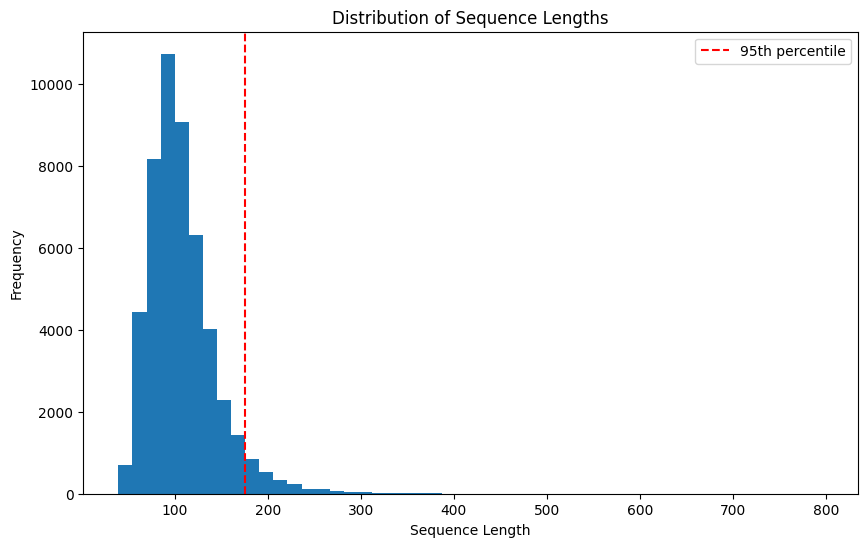

In [15]:
# 분석 실행
stats, lengths = analyze_sequence_lengths(dataset, tokenizer, template)

# 결과 출력
print("Sequence Length Statistics:")
print(f"Mean: {stats['mean']:.2f}")
print(f"Median: {stats['median']:.2f}")
print(f"95th percentile: {stats['p95']:.2f}")
print(f"99th percentile: {stats['p99']:.2f}")
print(f"Max: {stats['max']}")
print(f"Min: {stats['min']}")

# 히스토그램 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(stats['p95'], color='r', linestyle='--', label='95th percentile')
plt.legend()
plt.show()

In [16]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, ## 모델 파라미터를 NF4로 양자화.
    bnb_4bit_use_double_quant=True, ## 양자화 단계에서 발생하는 상수(scaling factor)도 양자화.
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, ## 연산 단계에서는 bf16으로 dequantize.
    bnb_4bit_quant_storage=torch.bfloat16, ## 양자화된 가중치를 저장할 때 사용할 데이터 타입.
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config = quantization_config,
    torch_dtype = torch.bfloat16,
    device_map = {"" : 0}
)

print(model)

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

In [ ]:
model = prepare_model_for_kbit_training(model) ## 모델 양자화

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
## adapter를 추가할 선형 모듈들이 무엇이 있는지 탐색.
def find_all_linear_names(model):
  cls = bnb.nn.Linear4bit
  lora_module_names = set()
  for name, module in model.named_modules():
    if isinstance(module, cls):
      names = name.split('.')
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])

  return list(lora_module_names)

print('Trainable targer module:',find_all_linear_names(model))

In [ ]:
model = get_peft_model(model, config)

In [ ]:
print(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

In [ ]:
#Hyper parameter setting
output_dir=f"{model_id.replace('/', '_')}-{data_id.replace('/', '_')}-QLoRA"

num_epochs = 1
train_batch_size = 4
valid_batch_size = 1
gradient_accumulation_steps = 16
warmup_steps = 10
learning_rate = 5e-7
group_by_length = False
optimizer = 'paged_adamw_8bit'

# adam 활용시
beta1 = 0.9
beta2 = 0.95

lr_scheduler = 'cosine'
logging_steps = 1

use_wandb = True
wandb_run_name = 'Single_GPU_Optim'

use_fp16 = False
use_bf_16 = True
evaluation_strategy = 'steps'
eval_steps = 50
save_steps = 50
save_strategy = 'steps'

model.gradient_checkpointing_enable()

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=TrainingArguments(per_device_train_batch_size=train_batch_size,
                           per_device_eval_batch_size=valid_batch_size,
                           gradient_accumulation_steps=gradient_accumulation_steps,
                           warmup_steps=warmup_steps,
                           num_train_epochs=num_epochs,
                           learning_rate=learning_rate,
                           adam_beta1=beta1,
                           adam_beta2=beta2,
                           fp16=use_fp16,
                           bf16=use_bf_16,
                           logging_steps=logging_steps,
                           optim=optimizer,
                           evaluation_strategy=evaluation_strategy if val_size > 0 else "no",
                           save_strategy="steps",  #스텝기준으로 save
                           eval_steps=eval_steps if val_size > 0 else None,
                           save_steps=save_steps,
                           lr_scheduler_type=lr_scheduler,
                           output_dir=output_dir,
                           #save_total_limit = 4,
                           load_best_model_at_end=True if val_size > 0 else False ,
                           group_by_length=group_by_length,
                           report_to="wandb" if use_wandb else None,
                           run_name=wandb_run_name if use_wandb else None),

    data_collator=DataCollatorForSeq2Seq(tokenizer, 
                                         pad_to_multiple_of=8, ## 패딩할 길이를 8의 배수로 맞춤(GPU 연산 최적화를 위해 시퀀스 길이를 8의 배수로 맞춤)
                                         return_tensors="pt", 
                                         padding=True), ## 배치 내 시퀀스들을 동일한 길이로 패딩
)

In [ ]:
model.config.use_cache = False
trainer.train()

In [ ]:
trainer.save_model()
tokenizer.save_pretrained(output_dir)

In [ ]:
# Trainer가 저장하는 것은 전체 모델 + 어뎁터가 아니라 어뎁터만 저장하는 것이기 때문에 별도로 base_model과 학습된 어뎁터를 병합하는 과정이 필요하다.

from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(model_id, token=hf_token)

merged_model = PeftModel.from_pretrained(base_model, output_dir)
merged_model = merged_model.merge_and_unload()

merged_model.push_to_hub(f"Pervinco/{output_dir}")
tokenizer.push_to_hub(f"Pervinco/{output_dir}")

In [ ]:
def load_model(model_path):
    """
    학습된 모델과 토크나이저를 로드하는 함수
    """
    # 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # 모델 설정 로드
    config = PeftConfig.from_pretrained(model_path)
    
    # 기본 모델 로드
    base_model = AutoModelForCausalLM.from_pretrained(
        config.base_model_name_or_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    
    # LoRA 모델 로드
    model = PeftModel.from_pretrained(base_model, model_path)
    
    return model, tokenizer

def generate_response(instruction, input_text=None, model=None, tokenizer=None, max_length=256):
    """
    주어진 instruction과 input에 대한 응답을 생성하는 함수
    """
    # 프롬프트 템플릿
    if input_text:
        prompt = f"아래는 문제를 설명하는 지시사항과 구체적인 답변 방식을 요구하는 입력이 함께 있는 문장입니다. 이 요청에 대해 적절하게 답변해주세요.\n###입력:{input_text}\n###지시사항:{instruction}\n###답변:"
    else:
        prompt = f"아래는 문제를 설명하는 지시사항입니다. 이 요청에 대해 적절하게 답변해주세요.\n###지시사항:{instruction}\n###답변:"
    
    # 입력 인코딩
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # 생성 파라미터 설정
    generation_config = {
        "max_new_tokens": max_length,
        "do_sample": True,
        "temperature": 0.7,
        "top_p": 0.9,
        "repetition_penalty": 1.1,
        "num_return_sequences": 1,
        "pad_token_id": tokenizer.eos_token_id,
    }
    
    # 텍스트 생성
    with torch.no_grad():
        outputs = model.generate(**inputs, **generation_config)
    
    # 디코딩 및 응답 추출
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = full_response.split("###답변:")[-1].strip()
    
    return response

In [ ]:
# 모델 경로 설정
model_path = "Pervinco/beomi_Llama-3-Open-Ko-8B-Bingsu_ko_alpaca_data-QLoRA"

# 모델 및 토크나이저 로드
print("모델을 로딩중입니다...")
model, tokenizer = load_model(model_path)
print("모델 로딩이 완료되었습니다.")

# 대화형 인터페이스
print("\n종료하려면 'quit' 또는 'exit'를 입력하세요.")
while True:
    # 사용자 입력 받기
    instruction = input("\n지시사항을 입력하세요: ")
    if instruction.lower() in ['quit', 'exit']:
        break
        
    input_text = input("입력(선택사항, 없으면 엔터): ")
    if not input_text:
        input_text = None
        
    # 응답 생성
    print("\n응답을 생성중입니다...")
    response = generate_response(instruction, input_text, model, tokenizer)
    print(f"\n응답: {response}")